# Prediction Model to Decide Who will Win Between Two World Cup Nations - the Final 16


In [237]:
import pandas as pd
import os

os.chdir('/Users/pierlim/PycharmProjects/fifa18_final16')
#os.chdir('/home/pier/Machine_Learning/fifa18_final16')
df_results = pd.read_csv('data/results.csv')
df_results = df_results[df_results['date'] > '2015-1-1']
df_results.head()
# df_new = df_results[(df_results['home_team'].str.contains("Germany")) | (df_results['away_team'].str.contains("Germany"))]
# df_new

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
126,3/2/00,Scotland,Wales,5,2,British Championship,Aberdeen,Scotland,False
127,24/2/00,Wales,Northern Ireland,2,0,British Championship,Llandudno,Wales,False
128,3/3/00,Northern Ireland,Scotland,0,3,British Championship,Belfast,Ireland,False
130,26/3/00,Wales,England,1,1,British Championship,Cardiff,Wales,False
131,7/4/00,Scotland,England,4,1,British Championship,Glasgow,Scotland,False


In [238]:
os.chdir('/Users/pierlim/PycharmProjects/fifa18_final16')
# os.chdir('/home/pier/Machine_Learning/fifa18_final16')
df_rankings = pd.read_csv('data/fifa_ranking.csv')
df_rankings = df_rankings[df_rankings['rank_date'].str.contains('2018')]
df_rankings =df_rankings.groupby('country_full')['rank', 'cur_year_avg_weighted'].mean()
df_rankings
# df_test = pd.DataFrame(df_test)
# df_test.reset_index()
df_rankings['country_full'] = df_rankings.index
# df_test[df_test['country_full'].str.contains('Germany')]
# df_test


# Join into the main dataset and cleaning

In [239]:
df_combined = df_results.set_index('home_team').join(df_rankings.set_index('country_full'))
df_combined.rename(columns={'rank' : 'home_rank', 'cur_year_avg_weighted' : 'home_weighted_points'}, inplace=True)
df_combined['home_team'] = df_combined.index
df_combined = df_combined.set_index('away_team').join(df_rankings.set_index('country_full'))
df_combined.rename(columns={'rank' : 'away_rank', 'cur_year_avg_weighted' : 'away_weighted_points'}, inplace=True)
df_combined['away_team'] = df_combined.index

Drop scores, and only use win/lose as the predictor.
Remove friendly and drawn matches as we are only interested in win/lose situations now. 

In [240]:
df_combined = df_combined.dropna()
df_combined = df_combined[~df_combined['tournament'].str.contains('Friendly')]
df_combined = df_combined[~(df_combined['home_score']==df_combined['away_score'])]
df_combined.head()


,date,home_score,away_score,tournament,city,country,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team
Afghanistan,5/3/79,3,2,AFC Asian Cup qualification,Dhaka,Bangladesh,False,196.500000,0.000,Bangladesh,145.166667,104.065,Afghanistan
Afghanistan,23/3/11,0,3,AFC Challenge Cup qualification,Gurgaon,India,True,185.833333,0.000,Bhutan,145.166667,104.065,Afghanistan
Afghanistan,7/12/11,1,8,SAFF Cup,New Delhi,India,True,185.833333,0.000,Bhutan,145.166667,104.065,Afghanistan
Afghanistan,26/12/15,0,3,SAFF Cup,Thiruvananthapuram,India,True,185.833333,0.000,Bhutan,145.166667,104.065,Afghanistan
Afghanistan,30/7/08,1,0,AFC Challenge Cup,Hyderabad,India,False,99.000000,202.945,India,145.166667,104.065,Afghanistan


Removal of the non-world cup matches seems to aid prediction

In [241]:
df_combined = df_combined[df_combined['tournament'].str.contains('World')]

# Feature generation

In [242]:
# Taking home team to be the one we are interested in 
df_combined['won'] = (df_combined['home_score'] - df_combined['away_score']) >= 1
df_combined.drop(['date', 'city', 'country','home_score','away_score'], axis=1, inplace=True)

In [243]:
df_combined['rank_diff'] = df_combined['home_rank'] - df_combined['away_rank']

In [244]:
df_combined['point_diff'] = df_combined['home_weighted_points'] - df_combined['away_weighted_points']
df_combined.head()

,tournament,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team,won,rank_diff,point_diff
Afghanistan,FIFA World Cup qualification,False,57.833333,220.966667,Japan,145.166667,104.065000,Afghanistan,True,-87.333333,116.901667
Afghanistan,FIFA World Cup qualification,False,171.666667,31.260000,Singapore,145.166667,104.065000,Afghanistan,True,26.500000,-72.805000
Afghanistan,FIFA World Cup qualification,False,75.000000,232.328333,Syria,145.166667,104.065000,Afghanistan,True,-70.166667,128.263333
Albania,FIFA World Cup qualification,False,94.666667,166.668333,Armenia,57.833333,243.603333,Albania,True,36.833333,-76.935000
Albania,FIFA World Cup qualification,False,12.000000,754.780000,Denmark,57.833333,243.603333,Albania,True,-45.833333,511.176667


In [245]:
df_combined.dtypes



tournament               object
neutral                    bool
home_rank               float64
home_weighted_points    float64
home_team                object
away_rank               float64
away_weighted_points    float64
away_team                object
won                        bool
rank_diff               float64
point_diff              float64
dtype: object

In [246]:
df_combined['won'] = df_combined['won'].astype(int)

# Data Balancing

In [247]:
from sklearn.utils import resample

df = df_combined
# Separate majority and minority classes
df_majority = df[df.won==1]
df_minority = df[df.won==0]
print(df_majority.shape)
print(df_minority.shape)
print(df_majority.shape[0])


(1875, 11)
(1006, 11)
1875


In [248]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.won.value_counts()
df_combined = df_upsampled

# Model Building

In [249]:
y = df_combined['won']
X = df_combined.drop(['won'], axis=1)

# Preprocessing one hot
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_cat = X.select_dtypes(include=[object, bool])
le = LabelEncoder()
X_cat_labelled = X_cat.apply(le.fit_transform)
X_cat_labelled.head()
X['home_team_orig'] = X['home_team']
X['away_team_orig'] = X['away_team']
X_tosee = pd.concat([X, X_cat_labelled], axis=1)
X_tosee[X_tosee['home_team_orig'].str.contains('England')]


,tournament,neutral,home_rank,home_weighted_points,home_team,away_rank,away_weighted_points,away_team,rank_diff,point_diff,home_team_orig,away_team_orig,tournament,neutral,home_team,away_team
Albania,FIFA World Cup qualification,False,14.333333,479.668333,England,57.833333,243.603333,Albania,-43.500000,236.065000,England,Albania,1,0,55,1
Albania,FIFA World Cup qualification,False,14.333333,479.668333,England,57.833333,243.603333,Albania,-43.500000,236.065000,England,Albania,1,0,55,1
Argentina,FIFA World Cup,False,14.333333,479.668333,England,4.500000,462.201667,Argentina,9.833333,17.466667,England,Argentina,0,0,55,8
Austria,FIFA World Cup qualification,False,14.333333,479.668333,England,27.333333,430.110000,Austria,-13.000000,49.558333,England,Austria,1,0,55,12
Azerbaijan,FIFA World Cup qualification,False,14.333333,479.668333,England,120.166667,81.073333,Azerbaijan,-105.833333,398.595000,England,Azerbaijan,1,0,55,13
Belgium,FIFA World Cup,True,14.333333,479.668333,England,4.000000,646.156667,Belgium,10.333333,-166.488333,England,Belgium,0,1,55,19
Croatia,FIFA World Cup qualification,False,14.333333,479.668333,England,16.833333,477.556667,Croatia,-2.500000,2.111667,England,Croatia,1,0,55,42
Denmark,FIFA World Cup qualification,False,14.333333,479.668333,England,12.000000,754.780000,Denmark,2.333333,-275.111667,England,Denmark,1,0,55,47
Ecuador,FIFA World Cup,True,14.333333,479.668333,England,64.500000,58.750000,Ecuador,-50.166667,420.918333,England,Ecuador,0,1,55,51
Egypt,FIFA World Cup,True,14.333333,479.668333,England,42.333333,273.918333,Egypt,-28.000000,205.750000,England,Egypt,0,1,55,52


In [250]:
X = pd.concat([X,pd.get_dummies(X_cat_labelled['home_team'], prefix='home_team')],axis=1)
X = pd.concat([X,pd.get_dummies(X_cat_labelled['away_team'], prefix='away_team')],axis=1)
X.to_csv('home_away_reference_new.csv')
X = X.drop(['tournament', 'neutral','home_team', 'away_team', 'home_team_orig', 'away_team_orig'], axis=1)
# X = pd.concat([X, X_cat_labelled], axis=1)
y = le.fit_transform(y)
# X.head()

# # # X.hist()
# # # plt.show()
# # # pd.DataFrame(y).hist()
# # # plt.show()

In [251]:
X
X.shape

(3750, 384)

# Correlation Matrix

In [252]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_combined.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


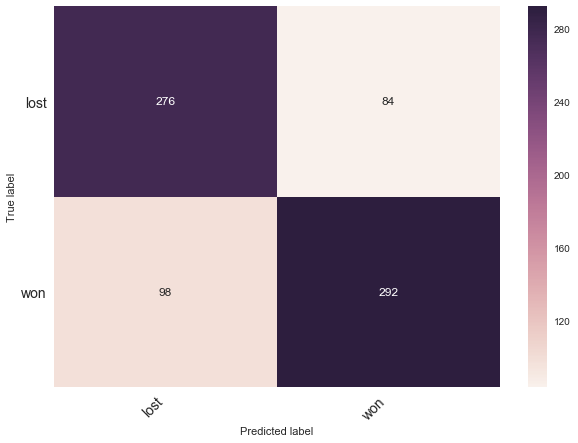

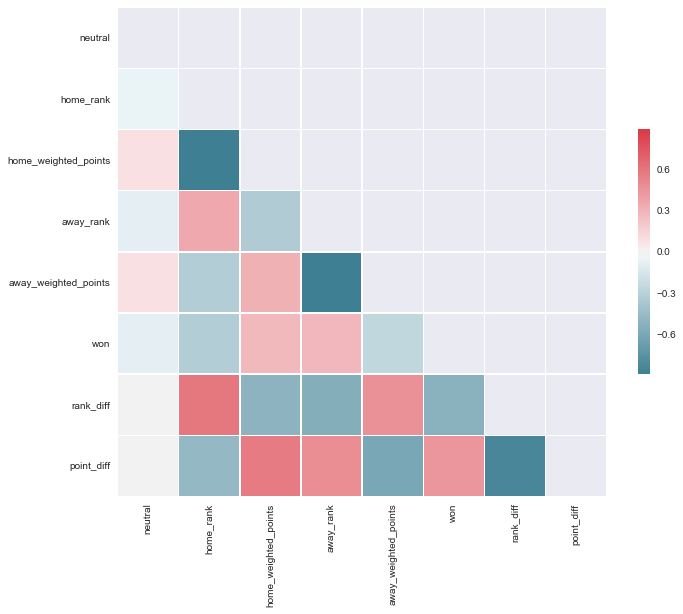

In [253]:
plt.show()

In [254]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,home_team_3,...,away_team_181,away_team_182,away_team_183,away_team_184,away_team_185,away_team_186,away_team_187,away_team_188,away_team_189,away_team_190
Hungary,20.333333,519.143333,50.5,193.130000,-30.166667,326.013333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chile,31.166667,421.830000,9.5,442.046667,21.666667,-20.216667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ecuador,14.500000,367.133333,64.5,58.750000,-50.000000,308.383333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Portugal,90.333333,218.515000,3.5,708.973333,86.833333,-490.458333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Angola,107.833333,183.293333,139.5,115.980000,-31.666667,67.313333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Do logistic regression with cross validation first

In [255]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# logreg = linear_model.LogisticRegression(C=0.013)
# features = PolynomialFeatures(degree=3)
# model = Pipeline([
#     ('polynomial_features', features),
#     ('logistic_regression', logreg)
# ])
# model = model.fit(X_train, y_train)

# Bayesian
# model = GaussianNB()
# model = model.fit(X_train, y_train)

# Random Forest
model = RandomForestClassifier(max_depth=3, random_state=0)
model.fit(X_train, y_train)


# clf = linear_model.LogisticRegression(C=0.013)
# # log_fit = clf.fit(X_train, y_train)
# # log_fit.score(X_test, y_test)
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([ 0.72166667,  0.72833333,  0.70166667,  0.72833333,  0.71      ])

In [256]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Test on test data

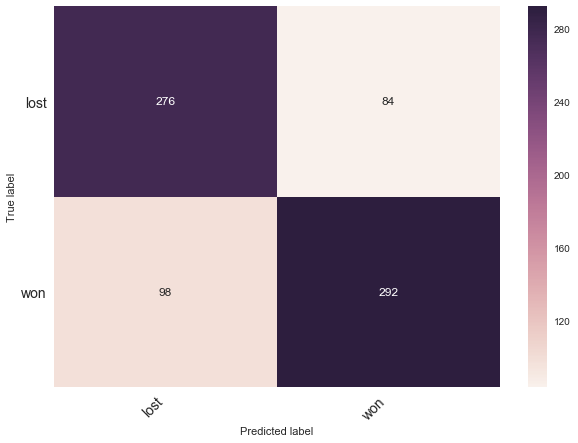

In [257]:
from sklearn import metrics
#model.score(X_test, y_test)
pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred )
print_confusion_matrix(cm, ['lost', 'won'])

In [258]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, accuracy_score

print('area under curve: {}'.format(roc_auc_score(y_test, pred)))
print('accuracy: {}'.format(accuracy_score(y_test, pred)))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

area under curve: 0.7576923076923076
accuracy: 0.7573333333333333
precision: [ 0.73796791  0.77659574]
recall: [ 0.76666667  0.74871795]
fscore: [ 0.7520436   0.76240209]
support: [360 390]


In [259]:
# Bayesian 0.71106382978723404
# Logistic 0.74416413373860191
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

# Simulation : Final 16 Results

In [261]:
df_final16 = pd.read_csv('data/X_final16.csv') # Pre-created data for Germany vs South Korea

In [262]:
df_final16


,Unnamed: 0,home_rank,home_weighted_points,away_rank,away_weighted_points,rank_diff,point_diff,home_team_0,home_team_1,home_team_2,...,away_team_181,away_team_182,away_team_183,away_team_184,away_team_185,away_team_186,away_team_187,away_team_188,away_team_189,away_team_190
0,1,8.000000,521.526667,4.500000,462.201667,3.500000,59.325000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,19.000000,395.455000,3.500000,708.973333,15.500000,-313.518333,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,7.333333,608.915000,64.666667,212.420000,-57.333334,396.495000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,16.833333,477.556667,12.000000,754.780000,4.833333,-277.223333,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2.000000,638.358333,16.000000,494.073333,-14.000000,144.285000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,4.000000,646.156667,57.833333,220.966667,-53.833333,425.190000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,21.000000,578.833333,7.000000,613.321667,14.000000,-34.488334,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,14.500000,367.133333,14.333333,479.668333,0.166667,-112.535000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [263]:
df_final16 = df_final16.drop(df_final16.columns[0], axis=1) # drop NA column

In [264]:
answer = model.predict(df_final16)

In [271]:
print('1 means a win for the 1st country.')
print('France vs Argentina : {}'.format(answer[0]))
print('Uruguay vs Portugal : {}'.format(answer[1]))
print('Spain vs Russia : {}'.format(answer[2]))
print('Croatia vs Denmark : {}'.format(answer[3]))
print('Brazil vs Mexico : {}'.format(answer[4]))
print('Belgium vs Japan : {}'.format(answer[5]))
print('Sweden vs Switzerland : {}'.format(answer[6]))
print('Colombia vs England : {}'.format(answer[7]))

1 means a win for the 1st country.
France vs Argentina : 1
Uruguay vs Portugal : 1
Spain vs Russia : 1
Croatia vs Denmark : 0
Brazil vs Mexico : 1
Belgium vs Japan : 1
Sweden vs Switzerland : 0
Colombia vs England : 0
